In [1]:
import argparse
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
from IPython.display import display
from multiprocessing import cpu_count,Pool 
from joblib import Parallel, delayed
import psutil
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN 
from sklearn.neighbors import NearestNeighbors
from itertools import cycle, islice
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import gmaps
#import hdbscan
import seaborn as sns


In [2]:
cores = cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want
print ("number of cores "+str(partitions))

number of cores 28


In [3]:
traffic_set = pd.read_hdf('../../data_set.h5',key='DS_new_sampled')
coords = traffic_set.as_matrix(columns=['LocationLat', 'LocationLng'])
print ('Loaded {} records'.format(len(coords)))
data = np.load("../../clustering_cordinates"+".npy")
loaded_labels = np.load("../../cluster_labels"+".npy")

Loaded 2000000 records


In [4]:
cluster_labels = loaded_labels
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 165


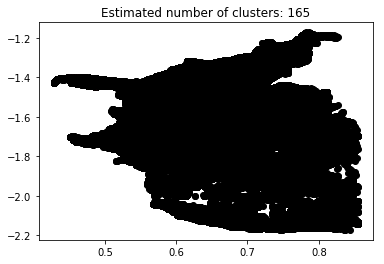

In [5]:
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
unique_labels = set(cluster_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (cluster_labels == k)

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % num_clusters)
plt.show()

In [6]:
_clusters = []
for c in clusters:
    if len(c)>1: _clusters.append(c)
clusters = pd.Series(_clusters)

# Find Cluster Centers


In [7]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [8]:
print (len(centermost_points))
centermost_points[0:5]

164


0    (32.812759, -96.941071)
1    (40.811741, -73.882942)
2    (38.979401, -77.026459)
3     (29.97105, -90.112846)
4    (25.966208, -80.229561)
dtype: object

#  Find Radius For Clusters


In [9]:
def get_farthest_point(cluster):   
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    farthest = max(cluster, key=lambda point: great_circle(point, centermost_point).miles)
    return tuple(farthest)
farthest_points = clusters.map(get_farthest_point)
farthest_points.head()

0    (32.697147, -97.540215)
1    (41.288811, -72.644882)
2    (39.621693, -75.991722)
3     (30.02865, -90.332451)
4    (27.010336, -80.103058)
dtype: object

In [10]:
radius = pd.Series([great_circle(centermost_points[n], farthest_points[n]).miles for n in range(len(centermost_points))])
print ('Average Radius: {:.2f} miles'.format(radius.mean()))

Average Radius: 14.33 miles


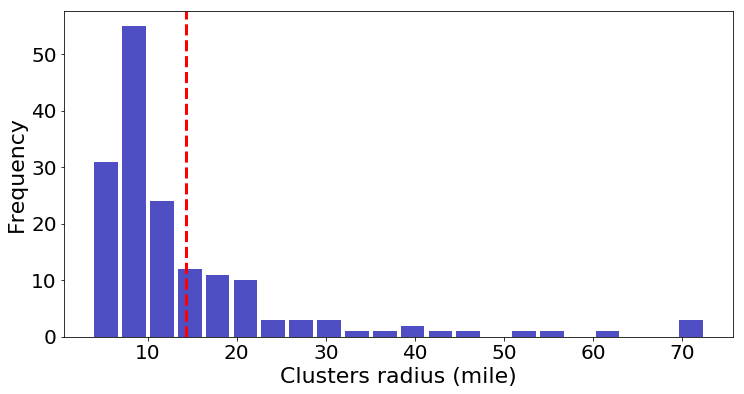

In [14]:
np.histogram(radius)
font= {'size': 20}
plt.rc('font', **font)
f = plt.figure(figsize=(12, 6))
plt.hist(radius,bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
#xlabels = [str(b) for b in bins[1:]]
plt.xlabel('Clusters radius (mile)', size=22)
plt.ylabel('Frequency', size=22)
plt.axvline(radius.mean(), color='red', linestyle='dashed', linewidth=3)
plt.show()
f.savefig("radius.pdf", bbox_inches='tight')

# Visualization of Cluster Centers

In [20]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.head()

,lat,lon
0,25.964245,-80.229271
1,40.812077,-73.886795
2,38.221607,-85.686531
3,33.985249,-118.071953
4,36.126873,-86.753128
